# Data Processing:

In [ ]:
from google.colab import files

# Upload file(s)
uploaded = files.upload()

In [ ]:
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")

Uploaded file: Test_NoAuction_DecPre.csv
Uploaded file: Train_NoAuction_DecPre.csv
Uploaded file: Test_NoAuction_Zscore.csv
Uploaded file: Train_NoAuction_Zscore.csv


In [ ]:
# Mount into drive

# from google.colab import drive

# drive.mount("/content/drive")

# %cd '/content/drive/MyDrive/Colab Notebooks/Money Printer/'

# !pip install -r requirements.txt
!pip install pandas
!pip install -U scikit-learn
!pip install torchinfo

In [1]:
# import data_loader
import pandas as pd
from pathlib import Path
import numpy as np
from torch.utils import data
import torch

In [2]:
train_data_all = pd.read_csv('Train_NoAuction_Zscore.csv')
test_data = pd.read_csv('Test_NoAuction_Zscore.csv')

In [3]:
#Split train data to train and validation sets:
train_data = train_data_all.iloc[:int(np.floor(train_data_all.shape[0]*0.8)), :]
val_data = train_data_all.iloc[int(np.floor(train_data_all.shape[0]*0.8)):, :]

In [4]:
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX, dataY

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization"""
        self.k = k
        self.num_classes = num_classes
        self.T = T

        x = data.iloc[:,:40]
        y = data.iloc[:,-5:]
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [6]:
batch_size = 64

dataset_train = Dataset(data=train_data, k=0, num_classes=3, T=10)
dataset_val = Dataset(data=val_data, k=0, num_classes=3, T=10)
# dataset_test = Dataset(data=test_data, k=0, num_classes=3, T=10)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

# print(dataset_train.x.shape, dataset_train.y.shape)

# Model Architecture:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [8]:
class MultiHeadSelfAttention(nn.Module):
    """
    Multi-head Self-Attention layer in PyTorch.
    """
    def __init__(self, d_model: int, num_heads: int, use_masking: bool = False):
        """
        :param d_model: Dimensionality of the input features.
        :param num_heads: Number of attention heads.
        :param use_masking: Whether to apply causal masking for autoregressive tasks.
        """
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads."

        self.d_model = d_model
        self.num_heads = num_heads
        self.use_masking = use_masking
        self.depth = d_model // num_heads

        # Query, Key, and Value projections
        self.qkv_proj = nn.Linear(d_model, d_model * 3, bias=False)

        # Output projection
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x: torch.Tensor):
        """
        Forward pass for multi-head self-attention.
        :param x: Input tensor of shape (batch_size, seq_len, d_model).
        :return: Output tensor of shape (batch_size, seq_len, d_model).
        """
        batch_size, seq_len, _ = x.size()

        # Project inputs to Query, Key, and Value tensors
        qkv = self.qkv_proj(x)  # (batch_size, seq_len, d_model * 3)
        q, k, v = torch.chunk(qkv, chunks=3, dim=-1)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.depth).permute(0, 2, 1, 3)
        k = k.view(batch_size, seq_len, self.num_heads, self.depth).permute(0, 2, 3, 1)
        v = v.view(batch_size, seq_len, self.num_heads, self.depth).permute(0, 2, 1, 3)

        # Scaled dot-product attention
        scores = torch.matmul(q, k) / np.sqrt(self.depth)  # (batch_size, num_heads, seq_len, seq_len)

        if self.use_masking:
            mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)
            scores = scores.masked_fill(mask, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        attention = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, depth)

        # Reshape and combine heads
        attention = attention.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, num_heads, depth)
        attention = attention.view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)

        # Apply output projection
        output = self.out_proj(attention)
        return output

In [9]:
class LayerNormalization(nn.Module):
    """
    Implementation of Layer Normalization.
    """
    def __init__(self, d_model: int, eps=1e-5):
        """
        :param d_model: Dimensionality of the input.
        :param eps: A small epsilon to avoid division by zero.
        """
        super(LayerNormalization, self).__init__()
        self.gain = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized = (x - mean) / torch.sqrt(variance + self.eps)
        return self.gain * normalized + self.bias


class TransformerTransition(nn.Module):
    """
    Transformer transition function with feed-forward layers.
    """
    def __init__(self, d_model: int, size_multiplier: int = 4, activation=F.relu):
        """
        :param d_model: Dimensionality of the input/output.
        :param size_multiplier: Multiplier for the hidden layer size.
        :param activation: Activation function.
        """
        super(TransformerTransition, self).__init__()
        self.activation = activation
        self.hidden_layer = nn.Linear(d_model, size_multiplier * d_model)
        self.output_layer = nn.Linear(size_multiplier * d_model, d_model)

    def forward(self, x):
        x = self.activation(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


class TransformerBlock(nn.Module):
    """
    A single Transformer block with self-attention, residual connections,
    normalization, and a feed-forward transition layer.
    """
    def __init__(self, d_model: int, num_heads: int, use_masking: bool = True, size_multiplier: int = 4, dropout_rate: float = 0.1):
        """
        :param d_model: Dimensionality of the model.
        :param num_heads: Number of attention heads.
        :param use_masking: Whether to apply masking in the attention mechanism.
        :param size_multiplier: Multiplier for the hidden size in the feed-forward layer.
        :param dropout_rate: Dropout probability.
        """
        super(TransformerBlock, self).__init__()
        self.self_attention = MultiHeadSelfAttention(d_model, num_heads, use_masking)
        self.norm1 = LayerNormalization(d_model)
        self.norm2 = LayerNormalization(d_model)
        self.transition = TransformerTransition(d_model, size_multiplier)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Self-attention with residual connection and layer normalization
        attention_output = self.self_attention(x)
        attention_output = self.dropout(attention_output)
        x = self.norm1(x + attention_output)

        # Feed-forward transition with residual connection and layer normalization
        transition_output = self.transition(x)
        transition_output = self.dropout(transition_output)
        x = self.norm2(x + transition_output)

        return x

In [10]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation):
        super(CausalConv1d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation)

    def forward(self, x):
        # Calculate the padding for causal convolution with dilation
        padding = (self.kernel_size - 1) * self.dilation
        # Pad the input tensor on the left (only past context)
        x = F.pad(x, (padding, 0), mode='constant', value=0)
        # Perform the convolution
        return self.conv(x)

In [11]:
class TransLOB(nn.Module):
    def __init__(self, n_classes=3):
        super(TransLOB, self).__init__()

        self.n_classes = n_classes
        # 1. Convolutional layers
        ## 1st convolution:

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        ## 2nd:
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )

        ## 3rd:
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # 2. Inception Layer:
        ##1st inc 1x1 3x1
        self.inc1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        ##2nd inc 1x1 5x1
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        ##3nd inc max_pool 1x1
        self.inc3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        #Dilated CNN:
        self.dilated = nn.Sequential(
            CausalConv1d(192, 14, kernel_size=2, stride=1, dilation=1),
            nn.ReLU(),
            CausalConv1d(14, 14, kernel_size=2, stride=1, dilation=2),
            nn.ReLU(),
            CausalConv1d(14, 14, kernel_size=2, stride=1, dilation=4),
            nn.ReLU(),
            CausalConv1d(14, 14, kernel_size=2, stride=1, dilation=8),
            nn.ReLU(),
            CausalConv1d(14, 14, kernel_size=2, stride=1, dilation=16),
            nn.ReLU(),
        )

        #Layer Normalization block:
        # self.norm1 = nn.LayerNorm()

        #Transformer block
        self.transformer1 = TransformerBlock(d_model=15, num_heads=3)
        self.transformer2 = TransformerBlock(d_model=15, num_heads=3)

        #Feed forward block (MLP)
        self.fc1 = nn.Linear(15*82,64)
        self.dropout = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def positional_encoding(self, x):
        """
        Adds positional encoding to the input tensor in PyTorch.
        :param x: Input tensor of shape (batch_size, steps, d_model)
        :return: Tensor with added positional encoding (batch_size, steps, d_model+1)
        """
        # Extract sequence length and model dimension
        steps, d_model = x.shape[1], x.shape[2]

        # Compute positional encoding
        ps = torch.linspace(-1, 1, steps, dtype=x.dtype, device=x.device).view(-1, 1)  # Shape: (steps, 1)
        ps = ps.unsqueeze(0).expand(x.size(0), -1, -1)  # Expand to batch size, Shape: (batch_size, steps, 1)

        # Concatenate positional encoding to the input
        x = torch.cat([x, ps], dim=-1)  # Shape: (batch_size, steps, d_model + 1)

        return x

    def forward(self, x):
        #Normal CNN
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        #Inception:
        inception1 = self.inc1(x)
        inception2 = self.inc2(x)
        inception3 = self.inc3(x)
        x = torch.cat((inception1, inception2, inception3), dim=1)

        # Reshape for Dilated CNN (from 4D to 3D)
        batch, channels, height, width = x.size()
        x = x.view(batch, channels, -1)


        #Dilated CNN:
        x = self.dilated(x)
        # x = self.norm1(x)


        #Positional encoding:
        x = x.permute(0, 2, 1)
        x = self.positional_encoding(x)
        # print(x.shape)

        #Transformer block:
        x = self.transformer1(x)
        x = self.transformer2(x)

        #MLP and output:
        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc1(x))
        x = self.relu(x)
        x = self.fc2(x)
        output = self.softmax(x)

        return output

In [12]:
model = TransLOB(n_classes = 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

TransLOB(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), strid

In [17]:
from torchinfo import summary
summary(model, (1, 1, 10, 40))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Conv2d: 2, LeakyReLU: 2, BatchNorm2d: 2, Conv2d: 2, LeakyReLU: 2, BatchNorm2d: 2, Conv2d: 2, LeakyReLU: 2, BatchNorm2d: 2, Conv2d: 2, Tanh: 2, BatchNorm2d: 2, Conv2d: 2, Tanh: 2, BatchNorm2d: 2]

# Training

In [14]:
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch_translob_k0.pt')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_losses, val_losses = batch_gd(model, criterion, optimizer,
                                    train_loader, val_loader, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (1 x 10). Kernel size: (4 x 1). Kernel size can't be greater than actual input size

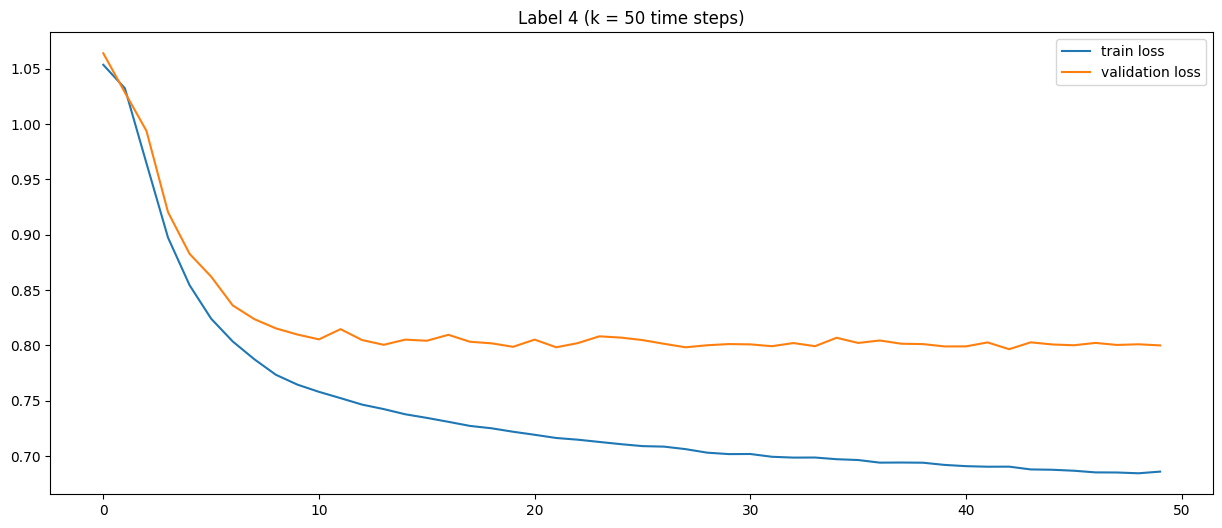

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.title('Label 4 (k = 50 time steps)')
plt.legend()

# **Testing Model**

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
from sklearn.metrics import accuracy_score, classification_report
model = torch.load('best_val_model_pytorch_translob_k4.pt')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

<ipython-input-15-d32c49fb9063>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_val_model_pytorch_translob_k4.pt')


Test acc: 0.7701


In [16]:
# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7700949185593026
              precision    recall  f1-score   support

           0     0.7326    0.7903    0.7603     47915
           1     0.8626    0.7560    0.8058     48050
           2     0.7273    0.7635    0.7449     43523

    accuracy                         0.7701    139488
   macro avg     0.7741    0.7699    0.7703    139488
weighted avg     0.7757    0.7701    0.7712    139488

